In [200]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets

In [201]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [202]:
latent_size = 100
hidden_size = 64
image_size = 64
num_epochs = 5
batch_size = 64
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

In [203]:
_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size)
]
)

In [204]:
trainset = datasets.MNIST(root='./data', train=True,
                          download=True, transform=_transforms)

mnist_loader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True)

In [205]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(latent_size, hidden_size * 8,
                               kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(hidden_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_size * 8, hidden_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_size * 4, hidden_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_size * 2, hidden_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)

In [206]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, hidden_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_size, hidden_size * 2,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_size * 2, hidden_size * 4,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_size * 4, hidden_size * 8,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_size * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)

In [207]:
criterion = nn.BCELoss()
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizerD = optim.Adam(discriminator.parameters(),
                        lr=lr, betas=(beta1, beta2))

In [213]:
def generate_images():
    fixed_noise = torch.randn(64, latent_size, 1, 1, device='cuda')
    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        fake, padding=2, normalize=True), (1, 2, 0)))
    plt.show()

In [209]:
total_step = len(mnist_loader)

In [210]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(mnist_loader, 0):
        images = images.to(device)

        noise = torch.randn(images.size(0), latent_size, 1, 1).to(device)

        fake_images = generator(noise)

        real_label = torch.ones(images.size(0), 1, 1, 1).to(device)
        fake_label = torch.zeros(images.size(0), 1, 1, 1).to(device)

        optimizerD.zero_grad()

        real_out = discriminator(images)
        real_loss = criterion(real_out, real_label)

        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_label)

        disc_loss = (real_loss + fake_loss)/2
        disc_loss.backward()
        optimizerD.step()

        optimizerG.zero_grad()

        outputs = discriminator(fake_images)
        gen_loss = criterion(outputs, real_label)

        gen_loss.backward()
        optimizerG.step()
        print(f"Discriminator Loss: {disc_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}")

C:\Users\Kiril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Discriminator Loss: 0.7310, Generator Loss: 2.3730
Discriminator Loss: 0.5728, Generator Loss: 3.4255
Discriminator Loss: 0.2847, Generator Loss: 4.7298
Discriminator Loss: 0.1914, Generator Loss: 4.5182
Discriminator Loss: 0.1423, Generator Loss: 4.9032
Discriminator Loss: 0.1069, Generator Loss: 5.4223
Discriminator Loss: 0.0753, Generator Loss: 5.6114
Discriminator Loss: 0.0657, Generator Loss: 5.9297
Discriminator Loss: 0.0506, Generator Loss: 6.0544
Discriminator Loss: 0.0475, Generator Loss: 6.0177
Discriminator Loss: 0.0368, Generator Loss: 6.4386
Discriminator Loss: 0.0293, Generator Loss: 6.5445
Discriminator Loss: 0.0376, Generator Loss: 6.8378
Discriminator Loss: 0.0304, Generator Loss: 6.9568
Discriminator Loss: 0.0208, Generator Loss: 6.7833
Discriminator Loss: 0.0170, Generator Loss: 6.6967
Discriminator Loss: 0.0121, Generator Loss: 6.7370
Discriminator Loss: 0.0119, Generator Loss: 6.7422
Discriminator Loss: 0.0153, Generator Loss: 6.9846
Discriminator Loss: 0.0117, Gen

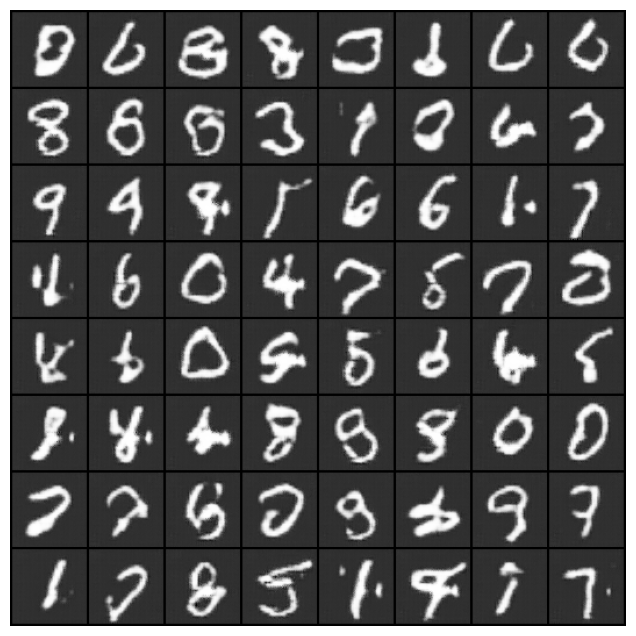

In [271]:
generate_images()